#EECS 442 PS5: Scene Recognition

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

[Your first name] [Your last name], [Your UMich uniqname]

__Important__: after you download the .ipynb file, please name it as __\<your_uniqname\>_\<your_umid\>.ipynb__ before you submit it to canvas. Example: adam_01101100.ipynb.




# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

data_dir = "./data_miniplaces_modified"

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118
Using the GPU!


# Problem 5.1 Scene Recognition with VGG

You will build and train a convolutional neural network for scene recognition, i.e., classifying images into different scenes. You will need to:
1. Construct dataloaders for train/val/test datasets
2. Build MiniVGG and MiniVGG-BN (MiniVGG with batch-normalization layers)
3. Train MiniVGG and MiniVGG-BN, compare their training progresses and their final top-1 and top-5 accuracies.
4. (Optional) Increase the size of the network by adding more layers and check whether top-1 and top-5 accuracies will improve.

## Step 0: Downloading the dataset.



In [ ]:
# Download the miniplaces dataset
# Note: Restarting the runtime won't remove the downloaded dataset. You only need to re-download the zip file if you lose connection to colab.
!wget http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip

--2023-10-09 19:08:05--  http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.116
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.116|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534628730 (510M) [application/zip]
Saving to: ‘data_miniplaces_modified.zip’

data_miniplaces_mod 100%[===================>] 509.86M  12.4MB/s    in 43s     

2023-10-09 19:08:49 (11.8 MB/s) - ‘data_miniplaces_modified.zip’ saved [534628730/534628730]



In [ ]:
# Unzip the download dataset .zip file to your local colab dir
# Warning: this upzipping process may take a while. Please be patient.
!unzip -q data_miniplaces_modified.zip

## 5.1 (a): Build dataloaders for train, val, and test

In [ ]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    """
    Build dataloaders with transformations.

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "val", "test" keys, each is mapped to a pytorch dataloader.
    """

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    ###########################################################################
    # TODO: Step 1: Build transformations for the dataset.                    #
    # You need to construct a data transformation that does three             #
    # preprocessing steps in order:                                           #
    # I. Resize the image to input_size using transforms.Resize               #
    # II. Convert the image to PyTorch tensor using transforms.ToTensor       #
    # III. Normalize the images with the provided mean and std parameters     #
    # using transforms.Normalize. These parameters are accumulated from a     #
    # large number of training samples.                                       #
    # You can use transforms.Compose to combine the above three               #
    # transformations. Store the combined transforms in the variable          #
    # 'composed_transform'.                                                   #
    ###########################################################################

    composed_transform = transforms.Compose([transforms.Resize(input_size),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean,std)])

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    # We write the remaining part of the dataloader for you.
    # You are encouraged to go through this.

    ###########################################################################
    # Step 2: Build dataloaders.                                              #
    # I. We use torch.datasets.ImageFolder with the provided data_dir and the #
    # data transfomations you created in step 1 to construct pytorch datasets #
    # for training, validation, and testing.                                  #
    # II. Then we use torch.utils.data.DataLoader to build dataloaders with   #
    # the constructed pytorch datasets. You need to enable shuffling for      #
    # the training set. Set num_workers=2 to speed up dataloading.            #
    # III. Finally, we put the dataloaders into a dictionary.                 #
    ###########################################################################

    # Create train/val/test datasets
    data_transforms = {
        'train': composed_transform,
        'val': composed_transform,
        'test': composed_transform
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}

    # Create training train/val/test dataloaders
    # Never shuffle the val and test datasets
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=2) for x in data_transforms.keys()}

    return dataloaders_dict

In [ ]:
batch_size = 16
input_size = 128
dataloaders_dict = get_dataloaders(input_size, batch_size)

# Confirm your train/val/test sets contain 90,000/10,000/10,000 samples
print('# of training samples {}'.format(len(dataloaders_dict['train'].dataset)))
print('# of validation samples {}'.format(len(dataloaders_dict['val'].dataset)))
print('# of test samples {}'.format(len(dataloaders_dict['test'].dataset)))

# of training samples 90000
# of validation samples 10000
# of test samples 10000


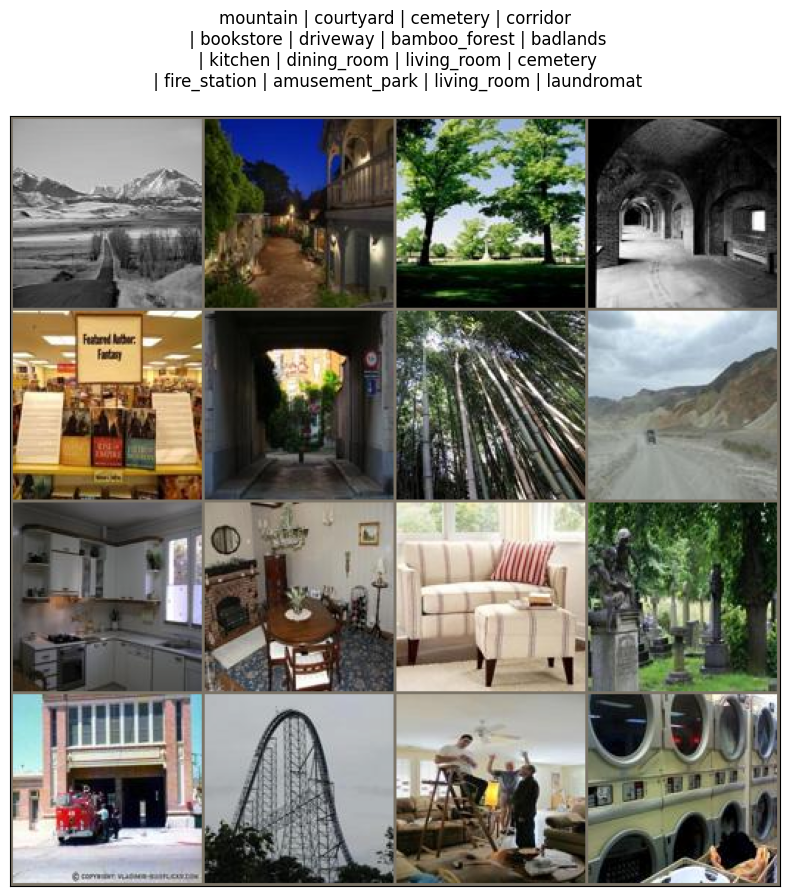

In [ ]:
# Visualize the data within the dataset
import json
with open('./data_miniplaces_modified/category_names.json', 'r') as f:
    class_names = json.load(f)['i2c']
class_names = {i:name for i, name in enumerate(class_names)}

def imshow(inp, title=None, ax=None, figsize=(10, 10)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 4 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

## 5.1 (b): Build MiniVGG and MiniVGG-BN

Please follow the instructions to build the two neural networks with architectures shown below.

__MiniVGG architecture__

![alt text](https://drive.google.com/uc?id=1RF3CjEsHBpRjubqwgBUxIEv54gpDjt95)

__MiniVGG-BN architecure__

![alt text](https://drive.google.com/uc?id=1HR5N2V-5RVT1u_bVzyCvhPJZ7PSnYm6x)


In [ ]:
# Helper function for counting number of trainable parameters.
def count_params(model):
    """
    Counts the number of trainable parameters in PyTorch.

    Args:
        model: PyTorch model.

    Returns:
        num_params: int, number of trainable parameters.
    """

    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])

    return num_params

In [ ]:
# Network configurations for all layers before the final fully-connected layers.
# "M" corresponds to maxpooling layer, integers correspond to number of output
# channels of a convolutional layer.
cfgs = {
    'MiniVGG': [64, 'M', 128, 'M', 128, 128, 'M'],
    'MiniVGG-BN': [64, 'M', 128, 'M', 128, 128, 'M']
}

def make_layers(cfg, batch_norm=False):
    """
    Return a nn.Sequential object containing all layers to get the features
    using the CNN. (That is, before the Average pooling layer in the two
    pictures above).

    Args:
      cfg: list
      batch_norm: bool, default: False. If set to True, a BatchNorm layer
                  should be added after each convolutional layer.

    Return:
      features: torch.nn.Sequential. Containers for all feature extraction
                layers. For use of torch.nn.Sequential, please refer to
                PyTorch documentation.
    """
    ###########################################################################
    # TODO: Construct the neural net architecture from cfg. You should use    #
    # nn.Sequential().                                                        #
    ###########################################################################

    if batch_norm:
      features = nn.Sequential(nn.Conv2d(3, cfgs['MiniVGG-BN'][0], kernel_size = (3,3), stride = (1,1), padding = (1,1)),
                               nn.BatchNorm2d(num_features=cfgs['MiniVGG-BN'][0], eps = 1e-05, momentum = 0.1, affine=True, track_running_stats=True),
                               nn.ReLU(inplace = True),
                               nn.MaxPool2d(kernel_size=2, stride = 2, padding = 0, dilation = 1, ceil_mode=False),
                               nn.Conv2d(cfgs['MiniVGG-BN'][0], cfgs['MiniVGG-BN'][2], kernel_size = (3,3), stride = (1,1), padding = (1,1)),
                               nn.BatchNorm2d(num_features=cfgs['MiniVGG-BN'][2], eps = 1e-05, momentum = 0.1, affine=True, track_running_stats=True),
                               nn.ReLU(inplace = True),
                               nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False),
                               nn.Conv2d(cfgs['MiniVGG-BN'][2], cfgs['MiniVGG-BN'][4], kernel_size = (3,3), stride = (1,1), padding = (1,1)),
                               nn.BatchNorm2d(num_features=cfgs['MiniVGG-BN'][4], eps = 1e-05, momentum = 0.1, affine=True, track_running_stats=True),
                               nn.ReLU(inplace = True),
                               nn.Conv2d(cfgs['MiniVGG-BN'][4], cfgs['MiniVGG-BN'][5], kernel_size = (3,3), stride = (1,1), padding = (1,1)),
                               nn.BatchNorm2d(num_features=cfgs['MiniVGG-BN'][5], eps = 1e-05, momentum = 0.1, affine=True, track_running_stats=True),
                               nn.ReLU(inplace = True),
                               nn.MaxPool2d(kernel_size=2, stride = 2, padding = 0, dilation = 1, ceil_mode = False))

    else:
      features = nn.Sequential(nn.Conv2d(3, cfgs['MiniVGG'][0], kernel_size = (3,3), stride = (1,1), padding = (1,1)),
                               nn.ReLU(inplace = True),
                               nn.MaxPool2d(kernel_size=2, stride = 2, padding = 0, dilation = 1, ceil_mode=False),
                               nn.Conv2d(cfgs['MiniVGG'][0], cfgs['MiniVGG'][2], kernel_size = (3,3), stride = (1,1), padding = (1,1)),
                               nn.ReLU(inplace = True),
                               nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False),
                               nn.Conv2d(cfgs['MiniVGG'][2], cfgs['MiniVGG'][4], kernel_size = (3,3), stride = (1,1), padding = (1,1)),
                               nn.ReLU(inplace = True),
                               nn.Conv2d(cfgs['MiniVGG'][4], cfgs['MiniVGG'][5], kernel_size = (3,3), stride = (1,1), padding = (1,1)),
                               nn.ReLU(inplace = True),
                               nn.MaxPool2d(kernel_size=2, stride = 2, padding = 0, dilation = 1, ceil_mode = False))

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return features

class VGG(nn.Module):

    def __init__(self, features, num_classes=100, init_weights=True):
        super(VGG, self).__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))

        #######################################################################
        # TODO: Construct the final FC layers using nn.Sequential.            #
        # Note: The average pooling layer has been defined by us above.       #
        #######################################################################
        self.classifier = nn.Sequential(nn.Linear(in_features=3200, out_features=512, bias = True),
                                          nn.ReLU(inplace =True),
                                          nn.Dropout(p = 0.3, inplace = False),
                                          nn.Linear(in_features=512, out_features=256, bias =True),
                                          nn.ReLU(inplace =True),
                                          nn.Dropout(p = 0.3, inplace =False),
                                          nn.Linear(in_features=256, out_features=num_classes, bias = True))


        #######################################################################
        #                              END OF YOUR CODE                       #
        #######################################################################

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [ ]:
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
vgg = VGG(features)

features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
vgg_bn = VGG(features)

# Print the network architectrue. Please compare the printed architecture with
# the one given in the instructions above.
# Make sure your network has the same architecture as the one we give above.
print(vgg)
print('Number of trainable parameters {}'.format(count_params(vgg)))

print(vgg_bn)
print('Number of trainable parameters {}'.format(count_params(vgg_bn)))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=Tru

## 5.1 (c): Build training/validation loops

You will write a function for training and validating the network.

In [ ]:
def make_optimizer(model):
    """
    Args:
        model: NN to train

    Returns:
        optimizer: pytorch optmizer for updating the given model parameters.
    """
    ###########################################################################
    # TODO: Create a SGD optimizer with learning rate=1e-2 and momentum=0.9.  #
    # HINT: Check out optim.SGD() and initialize it with the appropriate      #
    # parameters. We have imported torch.optim as optim for you above.        #
    ###########################################################################
    optimizer = optim.SGD(model.parameters(),lr = 1e-2, momentum = 0.9)
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################
    return optimizer

def get_loss():
    """
    Returns:
        criterion: pytorch loss.
    """
    ###########################################################################
    # TODO: Create an instance of the cross entropy loss. This code           #
    # should be a one-liner.                                                  #
    ###########################################################################
    criterion = nn.CrossEntropyLoss()
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return criterion

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):
    """
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    """

    val_acc_history = []
    tr_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                ###############################################################
                # TODO:                                                       #
                # Please read all the inputs carefully!                       #
                # For "train" phase:                                          #
                # (i)   Compute the outputs using the model                   #
                #       Also, use the  outputs to calculate the class         #
                #       predicted by the model,                               #
                #       Store the predicted class in 'preds'                  #
                #       (Think: argmax of outputs across a dimension)         #
                #       torch.max() might help!                               #
                # (ii)  Use criterion to store the loss in 'loss'             #
                # (iii) Update the model parameters                           #
                # Notes:                                                      #
                # - Don't forget to zero the gradients before beginning the   #
                # loop!                                                       #
                # - "val" phase is the same as train, but without backprop    #
                # - Compute the outputs (Same as "train", calculate 'preds'   #
                # too),                                                       #
                # - Calculate the loss and store it in 'loss'                 #
                ###############################################################
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs,labels)
                _, preds = torch.max(outputs,1)
                if phase == 'train':
                  loss.backward()
                  optimizer.step()


                ###############################################################
                #                         END OF YOUR CODE                    #
                ###############################################################

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # save the best model weights
                # =========================================================== #
                # IMPORTANT:
                # Losing your connection to colab will lead to loss of trained
                # weights.
                # You should download the trained weights to your local machine.
                # Later, you can load these weights directly without needing to
                # train the neural networks again.
                # =========================================================== #
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))

            # record the train/val accuracies
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)

    print('Best val Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history

## 5.1 (d): Train MiniVGG / MiniVGG-BN

In [ ]:
# Number of classes in the dataset
# Miniplaces has 100
num_classes = 100

# Batch size for training
batch_size = 128

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
# During debugging, you can set this parameter to 1
# num_epochs = 1
# Training for 20 epochs. This will take about half an hour.
num_epochs = 20

### IO
# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# get dataloaders and criterion function
input_size = 64
dataloaders = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion = get_loss()

In [ ]:
# Initialize MiniVGG
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
print(device)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg, tr_his, val_his = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG')

cuda:0
Epoch 0/19
----------


100%|██████████| 704/704 [01:23<00:00,  8.40it/s]


train Loss: 4.4894 Acc: 0.0207


100%|██████████| 79/79 [00:08<00:00,  9.59it/s]


val Loss: 4.2515 Acc: 0.0383
Epoch 1/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.68it/s]


train Loss: 4.0753 Acc: 0.0663


100%|██████████| 79/79 [00:08<00:00,  9.46it/s]


val Loss: 3.8725 Acc: 0.0986
Epoch 2/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.82it/s]


train Loss: 3.7658 Acc: 0.1135


100%|██████████| 79/79 [00:08<00:00,  9.46it/s]


val Loss: 3.5927 Acc: 0.1412
Epoch 3/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.78it/s]


train Loss: 3.5393 Acc: 0.1501


100%|██████████| 79/79 [00:07<00:00,  9.92it/s]


val Loss: 3.4122 Acc: 0.1741
Epoch 4/19
----------


100%|██████████| 704/704 [01:14<00:00,  9.46it/s]


train Loss: 3.3689 Acc: 0.1781


100%|██████████| 79/79 [00:07<00:00, 11.10it/s]


val Loss: 3.3097 Acc: 0.1874
Epoch 5/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.73it/s]


train Loss: 3.2246 Acc: 0.2046


100%|██████████| 79/79 [00:06<00:00, 11.59it/s]


val Loss: 3.1154 Acc: 0.2274
Epoch 6/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.57it/s]


train Loss: 3.1065 Acc: 0.2280


100%|██████████| 79/79 [00:06<00:00, 11.85it/s]


val Loss: 3.0218 Acc: 0.2428
Epoch 7/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.73it/s]


train Loss: 2.9829 Acc: 0.2510


100%|██████████| 79/79 [00:08<00:00,  9.62it/s]


val Loss: 2.9436 Acc: 0.2601
Epoch 8/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.87it/s]


train Loss: 2.8748 Acc: 0.2712


100%|██████████| 79/79 [00:08<00:00,  9.39it/s]


val Loss: 2.8980 Acc: 0.2714
Epoch 9/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.87it/s]


train Loss: 2.7829 Acc: 0.2904


100%|██████████| 79/79 [00:09<00:00,  8.06it/s]


val Loss: 2.7945 Acc: 0.2901
Epoch 10/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.82it/s]


train Loss: 2.6902 Acc: 0.3098


100%|██████████| 79/79 [00:06<00:00, 11.54it/s]


val Loss: 2.7650 Acc: 0.3013
Epoch 11/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.75it/s]


train Loss: 2.5962 Acc: 0.3280


100%|██████████| 79/79 [00:06<00:00, 11.49it/s]


val Loss: 2.7567 Acc: 0.3052
Epoch 12/19
----------


100%|██████████| 704/704 [01:14<00:00,  9.50it/s]


train Loss: 2.5110 Acc: 0.3452


100%|██████████| 79/79 [00:06<00:00, 11.46it/s]


val Loss: 2.7450 Acc: 0.3057
Epoch 13/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.82it/s]


train Loss: 2.4204 Acc: 0.3641


100%|██████████| 79/79 [00:07<00:00, 10.39it/s]


val Loss: 2.7307 Acc: 0.3124
Epoch 14/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.88it/s]


train Loss: 2.3309 Acc: 0.3819


100%|██████████| 79/79 [00:08<00:00,  9.36it/s]


val Loss: 2.7277 Acc: 0.3158
Epoch 15/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.71it/s]


train Loss: 2.2582 Acc: 0.3966


100%|██████████| 79/79 [00:08<00:00,  9.54it/s]


val Loss: 2.7487 Acc: 0.3120
Epoch 16/19
----------


100%|██████████| 704/704 [01:10<00:00, 10.01it/s]


train Loss: 2.1715 Acc: 0.4145


100%|██████████| 79/79 [00:08<00:00,  9.60it/s]


val Loss: 2.7372 Acc: 0.3133
Epoch 17/19
----------


100%|██████████| 704/704 [01:10<00:00, 10.01it/s]


train Loss: 2.0918 Acc: 0.4334


100%|██████████| 79/79 [00:07<00:00, 10.08it/s]


val Loss: 2.7502 Acc: 0.3181
Epoch 18/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.89it/s]


train Loss: 2.0150 Acc: 0.4479


100%|██████████| 79/79 [00:06<00:00, 11.72it/s]


val Loss: 2.7531 Acc: 0.3235
Epoch 19/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.75it/s]


train Loss: 1.9369 Acc: 0.4617


100%|██████████| 79/79 [00:06<00:00, 11.57it/s]

val Loss: 2.8220 Acc: 0.3184
Best val Acc: 0.323500


In [ ]:
# Initialize MiniVGG-BN
features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg_BN, tr_his_BN, val_his_BN = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG-BN')

Epoch 0/19
----------


100%|██████████| 704/704 [01:14<00:00,  9.45it/s]


train Loss: 4.2357 Acc: 0.0445


100%|██████████| 79/79 [00:06<00:00, 11.78it/s]


val Loss: 3.7531 Acc: 0.1074
Epoch 1/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.54it/s]


train Loss: 3.6132 Acc: 0.1299


100%|██████████| 79/79 [00:06<00:00, 11.80it/s]


val Loss: 3.4696 Acc: 0.1521
Epoch 2/19
----------


100%|██████████| 704/704 [01:14<00:00,  9.49it/s]


train Loss: 3.3447 Acc: 0.1765


100%|██████████| 79/79 [00:06<00:00, 11.38it/s]


val Loss: 3.2251 Acc: 0.1958
Epoch 3/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.62it/s]


train Loss: 3.1854 Acc: 0.2070


100%|██████████| 79/79 [00:07<00:00, 10.63it/s]


val Loss: 3.2304 Acc: 0.2037
Epoch 4/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.80it/s]


train Loss: 3.0558 Acc: 0.2323


100%|██████████| 79/79 [00:08<00:00,  9.48it/s]


val Loss: 3.0235 Acc: 0.2377
Epoch 5/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.79it/s]


train Loss: 2.9512 Acc: 0.2516


100%|██████████| 79/79 [00:08<00:00,  9.35it/s]


val Loss: 2.8801 Acc: 0.2654
Epoch 6/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.65it/s]


train Loss: 2.8570 Acc: 0.2713


100%|██████████| 79/79 [00:08<00:00,  9.52it/s]


val Loss: 2.8280 Acc: 0.2730
Epoch 7/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.78it/s]


train Loss: 2.7808 Acc: 0.2877


100%|██████████| 79/79 [00:08<00:00,  8.95it/s]


val Loss: 2.7495 Acc: 0.2988
Epoch 8/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.78it/s]


train Loss: 2.6959 Acc: 0.3048


100%|██████████| 79/79 [00:08<00:00,  9.48it/s]


val Loss: 2.7161 Acc: 0.3074
Epoch 9/19
----------


100%|██████████| 704/704 [01:14<00:00,  9.50it/s]


train Loss: 2.6250 Acc: 0.3206


100%|██████████| 79/79 [00:08<00:00,  9.31it/s]


val Loss: 2.7350 Acc: 0.3091
Epoch 10/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.63it/s]


train Loss: 2.5628 Acc: 0.3324


100%|██████████| 79/79 [00:08<00:00,  9.48it/s]


val Loss: 2.6588 Acc: 0.3169
Epoch 11/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.66it/s]


train Loss: 2.4950 Acc: 0.3446


100%|██████████| 79/79 [00:08<00:00,  9.50it/s]


val Loss: 2.6235 Acc: 0.3236
Epoch 12/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.79it/s]


train Loss: 2.4318 Acc: 0.3599


100%|██████████| 79/79 [00:08<00:00,  9.55it/s]


val Loss: 2.5686 Acc: 0.3406
Epoch 13/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.57it/s]


train Loss: 2.3712 Acc: 0.3723


100%|██████████| 79/79 [00:08<00:00,  9.59it/s]


val Loss: 2.5748 Acc: 0.3421
Epoch 14/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.65it/s]


train Loss: 2.3098 Acc: 0.3850


100%|██████████| 79/79 [00:08<00:00,  9.64it/s]


val Loss: 2.5915 Acc: 0.3345
Epoch 15/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.74it/s]


train Loss: 2.2504 Acc: 0.3972


100%|██████████| 79/79 [00:08<00:00,  9.52it/s]


val Loss: 2.5458 Acc: 0.3482
Epoch 16/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.68it/s]


train Loss: 2.1919 Acc: 0.4089


100%|██████████| 79/79 [00:08<00:00,  9.46it/s]


val Loss: 2.4775 Acc: 0.3642
Epoch 17/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.64it/s]


train Loss: 2.1381 Acc: 0.4218


100%|██████████| 79/79 [00:08<00:00,  9.62it/s]


val Loss: 2.4740 Acc: 0.3641
Epoch 18/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.81it/s]


train Loss: 2.0823 Acc: 0.4331


100%|██████████| 79/79 [00:07<00:00, 10.21it/s]


val Loss: 2.4792 Acc: 0.3575
Epoch 19/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.71it/s]


train Loss: 2.0298 Acc: 0.4450


100%|██████████| 79/79 [00:06<00:00, 11.42it/s]

val Loss: 2.4847 Acc: 0.3553
Best val Acc: 0.364200


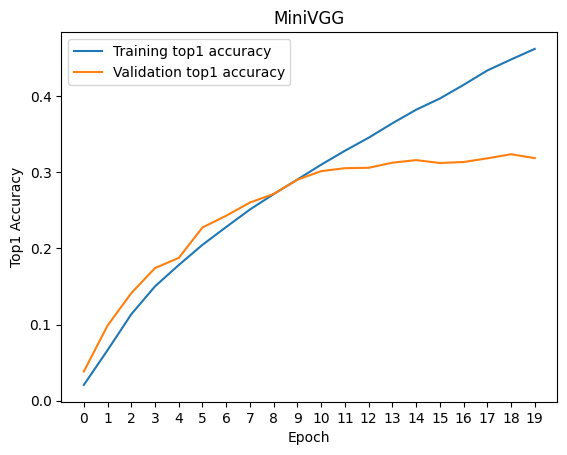

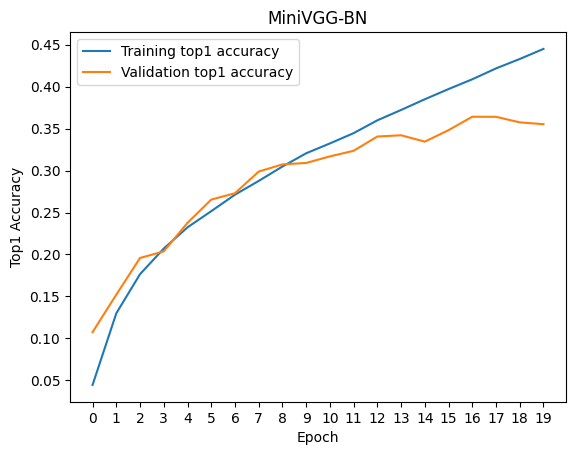

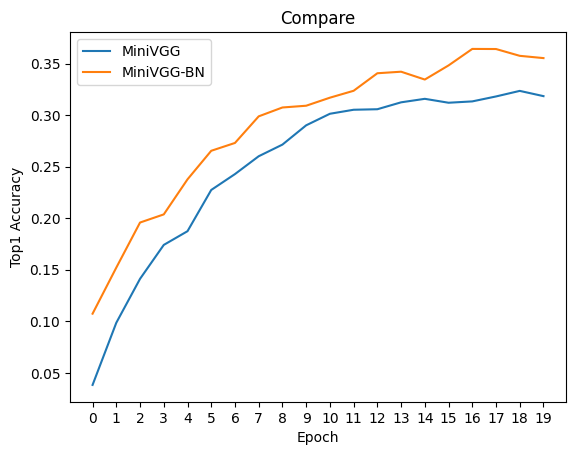

In [ ]:
x = np.arange(num_epochs)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, torch.tensor(tr_his, device = 'cpu'))
plt.plot(x, torch.tensor(val_his, device = 'cpu'))
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG')
plt.show()

# train/val accuracies for MiniVGG-BN
plt.plot(x, torch.tensor(tr_his_BN, device = 'cpu'))
plt.plot(x, torch.tensor(val_his_BN, device = 'cpu'))
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG-BN')
plt.show()

# compare val accuracies of MiniVGG and MiniVGG-BN
plt.plot(x, torch.tensor(val_his, device = 'cpu'))
plt.plot(x, torch.tensor(val_his_BN, device = 'cpu'))
plt.legend(['MiniVGG', 'MiniVGG-BN'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('Compare')
plt.show()

### TODO: __Summarize the effect of batch normalization:__






In [ ]:
# Answer here
Batch norm results in higher accuracy at earlier epochs.

In [ ]:
pickle.dump(tr_his, open('tr_his.pkl', 'wb'))
pickle.dump(tr_his_BN, open('tr_his_BN.pkl', 'wb'))
pickle.dump(val_his, open('val_his.pkl', 'wb'))
pickle.dump(val_his_BN, open('val_his_BN.pkl', 'wb'))

## Step 6. Measure top1 and top5 accuracies of MiniVGG and MiniVGG-BN

__Definition of top-k accuracy__: if the correct label is within the _top k_ predicted classes according to the network output scores, we count the prediction by the neural network as a correct prediction.

In [ ]:
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values
    of k.

    Args:
        output: pytorch tensor, (batch_size x num_classes). Outputs of the
                network for one batch.
        target: pytorch tensor, (batch_size,). True labels for one batch.

    Returns:
        res: list. Accuracies corresponding to topk[0], topk[1], ...
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def test(model, dataloader):

    model.eval()

    top1_acc = []
    top5_acc = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            res = accuracy(outputs, labels, topk=(1, 5))

            top1_acc.append(res[0] * len(outputs))
            top5_acc.append(res[1] * len(outputs))

    print('Top-1 accuracy {}%, Top-5 accuracy {}%'.format(sum(top1_acc).item()/10000, sum(top5_acc).item()/10000))

In [ ]:
##### To pass the test, both networks should have Top-5 accuracy above 55% #####
vgg_BN.load_state_dict(torch.load('./weights/MiniVGG-BN.pth'))
vgg.load_state_dict(torch.load('./weights/MiniVGG.pth'))

test(vgg_BN, dataloaders['test'])
test(vgg, dataloaders['test'])

Top-1 accuracy 35.99%, Top-5 accuracy 66.85%
Top-1 accuracy 32.54%, Top-5 accuracy 61.8%


## 5.2 (a-b): Build small ResNet model (Optional)

Please follow this figure to build the Residual Block and the Resnet model. We already implemented the back bone of the resnet model. You have to code the ResNet Block and the classifier part which are shown in the figure.

__ResNet architecture__

![alt text](https://drive.google.com/uc?id=1IlNfXwxYzTJC3FtmydDs07Z5Z9IWatde)





In [ ]:

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1):
        super(ResidualBlock, self).__init__()
        ###########################################################################
        # TODO: Code the residual block as depicted in the above figure. You should use    #
        # nn.Sequential().                                                        #
        ###########################################################################

        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.relu = nn.ReLU()
        self.out_channels = out_channels


        #######################################################################
        #                              END OF YOUR CODE                       #
        #######################################################################

    def forward(self, x):

        ###########################################################################
        # TODO: Code the forward pass for the residual block as depicted in the above figure.
        # Note: The relu activation function is after the skip connection.                                                        #
        ###########################################################################

        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        out += residual
        out = self.relu(out)


        #######################################################################
        #                              END OF YOUR CODE                       #
        #######################################################################
        return out

In [ ]:

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()

        ###########################################################################
        # Construct the neural net architecture for the resnet model. You should use nn.Sequential().
        # Note: We already implemented most of the network you just need to code the initial layers and insert the residual blocks.
        ###########################################################################

        self.backbone = nn.Sequential(
                        ###########################################################################
                        # TODO: Code the initial layers i.e the the strided convolution layer, batchnorm, relu, maxpool layer and the residual blocks
                        #Hint: you have to make use of the "block" variable.
                        ###########################################################################

                        nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU()),
                        nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
                        block(64, 64, 1),

                        #######################################################################
                        #                              END OF YOUR CODE                       #
                        #######################################################################
                        nn.Sequential(
                        nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1),
                        nn.BatchNorm2d(128),
                        nn.ReLU()),
                        ###########################################################################
                        # TODO: Insert the residual block please follow the figure for the number of channels and the flow of layers.
                        ###########################################################################

                        block(128, 128, 1),
                        #######################################################################
                        #                              END OF YOUR CODE                       #
                        #######################################################################
                        nn.Sequential(
                        nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1),
                        nn.BatchNorm2d(256),
                        nn.ReLU()),
                        ###########################################################################
                        # TODO: Insert the residual block please follow the figure for the number of channels and the flow of layers.
                        ###########################################################################

                        block(256, 256, 1),
                        #######################################################################
                        #                              END OF YOUR CODE                       #
                        #######################################################################
                        nn.Sequential(
                        nn.Conv2d(256, 512, kernel_size = 3, stride = 2, padding = 1),
                        nn.BatchNorm2d(512),
                        nn.ReLU()),
                        ###########################################################################
                        # TODO: Insert the residual block please follow the figure for the number of channels and the flow of layers.
                        ###########################################################################

                        block(512, 512, 1))

                        #######################################################################
                        #                              END OF YOUR CODE                       #
                        #######################################################################


        self.avgpool = nn.AvgPool2d(2, stride=1)
        self.fc = nn.Linear(512, num_classes)


    def forward(self, x):
        x = self.backbone(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:

resnet = ResNet(ResidualBlock, [1, 1, 1, 1], 100)
print(resnet)
print('Number of trainable parameters {}'.format(count_params(resnet)))


ResNet(
  (backbone): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

## 5.2 (c): Train ResNet

In [ ]:

# Initialize ResNet
resnet = ResNet(ResidualBlock, [1, 1, 1, 1], num_classes).to(device)
optimizer = make_optimizer(resnet)

# Train the model!
resnet, tr_his_res, val_his_res = train_model(model=resnet, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='ResNet')



Epoch 0/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.71it/s]


train Loss: 3.6712 Acc: 0.1338


100%|██████████| 79/79 [00:07<00:00, 11.16it/s]


val Loss: 3.3671 Acc: 0.1801
Epoch 1/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.52it/s]


train Loss: 3.1405 Acc: 0.2214


100%|██████████| 79/79 [00:07<00:00, 11.08it/s]


val Loss: 3.1646 Acc: 0.2175
Epoch 2/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.60it/s]


train Loss: 2.8580 Acc: 0.2752


100%|██████████| 79/79 [00:06<00:00, 11.80it/s]


val Loss: 2.9284 Acc: 0.2654
Epoch 3/19
----------


 58%|█████▊    | 405/704 [00:43<00:32,  9.28it/s]


KeyboardInterrupt: ignored

In [ ]:

# train/val accuracies for ResNet
plt.figure()
plt.plot(x, torch.tensor(tr_his_res, device = 'cpu'))
plt.plot(x, torch.tensor(val_his_res, device = 'cpu'))
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('ResNet')
plt.show()

In [ ]:
pickle.dump(tr_his_res, open('tr_his_res.pkl', 'wb'))
pickle.dump(val_his_res, open('val_his_res.pkl', 'wb'))

In [ ]:
##### (Optional) Network should have Top-5 accuracy above 55% #####
resnet.load_state_dict(torch.load('./weights/ResNet.pth'))
test(resnet, dataloaders['test'])

# Convert Notebook to PDF


In [ ]:
# generate pdf
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!
import os
notebookpath = '' # Ex: notebookpath = '/content/drive/My Drive/Colab Notebooks/EECS 442 Fall 2023 - PS1.ipynb'
drive_mount_point = '/content/drive/'
from google.colab import drive
drive.mount(drive_mount_point)
file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("pip install pypandoc")
get_ipython().system("apt-get install texlive texlive-xetex texlive-latex-extra pandoc")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
from google.colab import files
files.download(notebookpath.split('.')[0]+'.pdf')